In [2]:
# ==========================================================
# Agreement Phase Partitioning
# Voxel labeling by dominant local state; boundary movement
# ==========================================================
import os, json
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter, distance_transform_edt, binary_opening, binary_closing, label
from sklearn.neighbors import KDTree
from skimage.measure import marching_cubes
import trimesh
import matplotlib.pyplot as plt

# --------------------- USER INPUTS ---------------------
DELTAS_CSV = "data/green_monkey/all_structure_files/chr1/temporal_data/chr1_temporal_trendCategories_valuePattern.csv"

# Per-timepoint XYZ (same gene_name key)
XYZ = {
    "12h": "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv",
    "18h": "data/green_monkey/all_structure_files/chr1/18hrs/vacv/structure_18hrs_vacv_gene_info.csv",
    # "24h": "data/green_monkey/all_structure_files/chr1/24hrs/vacv/structure_24hrs_vacv_gene_info.csv",
}
KEY = "gene_name"

# If you don't have precomputed states, we derive them from these columns:
FAMILY_COLS = {
    "expr": {"12h": "expr_delta_12h", "18h": "expr_delta_18h", "24h": "expr_delta_24h"},
    "acc":  {"12h": "acc_delta_12h_tss", "18h": "acc_delta_18h_tss", "24h": "acc_delta_24h_tss"},
}

# Grid & kernel
GRID_RES    = 128          # 64–192 reasonable
GRID_MARGIN = 10.0         # padding around union bbox
VOTE_RADIUS = 12.0         # local vote radius (same units as XYZ)
GAUSS_SIGMA = None         # if None → auto from VOTE_RADIUS/voxel_step

# Probabilities → region threshold
PROB_THRESH = 0.50         # boundary at p >= τ
MIN_BLOB_VOX = 1200        # drop tiny specks after thresholding

# Smoothing for probabilities before thresholding (stabilize shells)
PROB_SMOOTH_SIG = 1.0

# Colors (RGBA) for GLB
COLOR = {
    "agree_up":   (255, 120,   0, 220),  # orange
    "agree_down": ( 30, 170, 255, 220),  # cyan/blue
    "conflict":   (190,  60, 210, 220),  # magenta/purple
}

OUT_DIR = "data/green_monkey/va_testing/agreement_phase"
TAG     = "chr1_vacv"
os.makedirs(OUT_DIR, exist_ok=True)

# --------------------- HELPERS ---------------------
CLASSES = ["agree_up", "agree_down", "conflict"]
CLS_IDX = {c:i for i,c in enumerate(CLASSES)}

def load_points(csv_path, key=KEY):
    df = pd.read_csv(csv_path)
    need = [key, "middle_x", "middle_y", "middle_z"]
    for c in need:
        if c not in df.columns:
            raise ValueError(f"Missing column {c} in {csv_path}")
    df = df[need].dropna().rename(columns={"middle_x":"x","middle_y":"y","middle_z":"z"})
    return df

def merge_xy(deltas_csv, xyz_csv, key=KEY):
    df_d = pd.read_csv(deltas_csv)
    df_x = load_points(xyz_csv, key)
    df = pd.merge(df_d, df_x, on=key, how="inner")
    return df

def make_union_grid(point_sets, margin=GRID_MARGIN, res=GRID_RES):
    P = np.vstack(point_sets)
    mins = P.min(0) - margin
    maxs = P.max(0) + margin
    spans = maxs - mins
    step = spans.max() / (res - 1)
    nx = int(round(spans[0]/step)) + 1
    ny = int(round(spans[1]/step)) + 1
    nz = int(round(spans[2]/step)) + 1
    xs = mins[0] + np.arange(nx)*step
    ys = mins[1] + np.arange(ny)*step
    zs = mins[2] + np.arange(nz)*step
    return xs, ys, zs, step

def grid_points(xs, ys, zs):
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    return np.stack([X, Y, Z], axis=-1).reshape(-1, 3)

def derive_states_if_missing(df, t, families=FAMILY_COLS, q=25):
    """If df has a column 'state_{t}', return it; else derive from expr/acc signs with epsilon."""
    col = f"state_{t}"
    if col in df.columns:
        return df[col].astype(str).fillna("neutral").values

    # derive from (expr, acc) at time t
    if t not in families["expr"] or t not in families["acc"]:
        raise ValueError(f"No columns to derive states for {t}. Provide state_{t} in CSV or map FAMILY_COLS.")

    e_col = families["expr"][t]
    a_col = families["acc"][t]
    if e_col not in df.columns or a_col not in df.columns:
        raise ValueError(f"Missing columns {e_col}/{a_col} to derive states at {t}.")

    e = df[e_col].to_numpy(float)
    a = df[a_col].to_numpy(float)
    # robust epsilons (ignore tiny noise)
    eps_e = np.nanpercentile(np.abs(e[np.isfinite(e)]), q)
    eps_a = np.nanpercentile(np.abs(a[np.isfinite(a)]), q)

    se = np.where(np.abs(e) >= eps_e, np.sign(e), 0)
    sa = np.where(np.abs(a) >= eps_a, np.sign(a), 0)

    state = np.full(len(df), "neutral", dtype=object)
    state[(se== 1) & (sa== 1)] = "agree_up"
    state[(se==-1) & (sa==-1)] = "agree_down"
    state[(se*sa)==-1]         = "conflict"   # opposite signs
    return state

def splat_class_counts(df, xs, ys, zs, states):
    """Nearest-voxel splat of per-gene class counts into K channels, then Gaussian to approximate local vote."""
    nx, ny, nz = len(xs), len(ys), len(zs)
    K = len(CLASSES)
    vol = np.zeros((nx, ny, nz, K), dtype=np.float32)

    # map points to nearest voxel
    ix = np.clip(np.round((df["x"].values - xs[0])/(xs[1]-xs[0])).astype(int), 0, nx-1)
    iy = np.clip(np.round((df["y"].values - ys[0])/(ys[1]-ys[0])).astype(int), 0, ny-1)
    iz = np.clip(np.round((df["z"].values - zs[0])/(zs[1]-zs[0])).astype(int), 0, nz-1)

    for i,(a,b,c) in enumerate(zip(ix,iy,iz)):
        st = states[i]
        if st in CLS_IDX:
            vol[a,b,c, CLS_IDX[st]] += 1.0

    # blur each channel with sigma ≈ VOTE_RADIUS
    step = ((xs[1]-xs[0]) + (ys[1]-ys[0]) + (zs[1]-zs[0]))/3.0
    sigma = (VOTE_RADIUS/step) if GAUSS_SIGMA is None else GAUSS_SIGMA
    for k in range(K):
        vol[:,:,:,k] = gaussian_filter(vol[:,:,:,k], sigma=sigma, mode="nearest")

    # optional light smoothing to stabilize probabilities
    if PROB_SMOOTH_SIG and PROB_SMOOTH_SIG > 0:
        for k in range(K):
            vol[:,:,:,k] = gaussian_filter(vol[:,:,:,k], sigma=PROB_SMOOTH_SIG, mode="nearest")

    # convert to probabilities
    s = vol.sum(axis=3, keepdims=True) + 1e-8
    prob = vol / s
    # argmax labels + confidence
    lbl_idx = np.argmax(prob, axis=3)  # (nx,ny,nz)
    # confidence = p_max - p_second
    sortp = np.sort(prob, axis=3)
    conf = sortp[:,:,:, -1] - sortp[:,:,:, -2]
    return prob, lbl_idx.astype(np.int16), conf.astype(np.float32)

def threshold_and_clean(prob_c, thr=PROB_THRESH, min_vox=MIN_BLOB_VOX):
    mask = prob_c >= thr
    mask = binary_opening(mask, iterations=1)
    mask = binary_closing(mask, iterations=1)
    lab, n = label(mask)
    keep = np.zeros_like(mask, bool)
    for i in range(1, n+1):
        if (lab==i).sum() >= min_vox:
            keep |= (lab==i)
    return keep

def export_mask_as_glb(mask, xs, ys, zs, rgba, out_path):
    vol = np.transpose(mask.astype(np.float32), (2,1,0))  # z,y,x for marching_cubes
    spacing = (zs[1]-zs[0], ys[1]-ys[0], xs[1]-xs[0])
    v,f,n,_ = marching_cubes(vol, level=0.5, spacing=spacing)
    mesh = trimesh.Trimesh(vertices=v[:, ::-1], faces=f, vertex_normals=n[:, ::-1], process=False)
    mesh.visual.vertex_colors = np.tile(np.array(rgba, np.uint8), (len(mesh.vertices),1))
    mesh.export(out_path)
    return mesh

def signed_distance(mask, step):
    outside = distance_transform_edt(~mask) * step
    inside  = distance_transform_edt(mask) * step
    sdf = outside.astype(np.float32)
    sdf[mask] = -inside[mask]
    return sdf

# --------------------- BUILD GRID (union of times) ---------------------
dfs = {}
points = []
for t, path in XYZ.items():
    df = merge_xy(DELTAS_CSV, path, KEY)
    dfs[t] = df
    points.append(df[["x","y","z"]].to_numpy(float))
xs, ys, zs, step = make_union_grid(points, margin=GRID_MARGIN, res=GRID_RES)
nx, ny, nz = len(xs), len(ys), len(zs)

# --------------------- PER-TIME: PROB & LABEL VOLUMES ---------------------
prob_vols = {}     # t -> (nx,ny,nz,K)
label_vols = {}    # t -> (nx,ny,nz)
conf_vols = {}     # t -> (nx,ny,nz)

for t, df in dfs.items():
    states = derive_states_if_missing(df, t)  # uses state_t if present; else derive from expr/acc
    prob, lbl, conf = splat_class_counts(df, xs, ys, zs, states)
    prob_vols[t] = prob
    label_vols[t] = lbl
    conf_vols[t] = conf
    # save volumes
    np.save(os.path.join(OUT_DIR, f"{TAG}_{t}_prob.npy"), prob)
    np.save(os.path.join(OUT_DIR, f"{TAG}_{t}_label.npy"), lbl)
    np.save(os.path.join(OUT_DIR, f"{TAG}_{t}_conf.npy"), conf)

np.save(os.path.join(OUT_DIR, f"{TAG}_grid_axes.npy"), np.array([xs, ys, zs], dtype=object))

# --------------------- EXPORT REGIONS (surfaces) ---------------------
# For each time and each class, threshold prob ≥ τ, clean, export GLB
glb_regions = []  # (time, class, path)
for t in prob_vols:
    prob = prob_vols[t]
    for cls, idx in CLS_IDX.items():
        mask = threshold_and_clean(prob[:,:,:,idx], thr=PROB_THRESH, min_vox=MIN_BLOB_VOX)
        if mask.sum() == 0: 
            continue
        outp = os.path.join(OUT_DIR, f"{TAG}_{t}_{cls}_region.glb")
        try:
            export_mask_as_glb(mask, xs, ys, zs, COLOR[cls], outp)
            glb_regions.append((t, cls, outp))
            print("Exported:", outp)
        except Exception as e:
            print("Skip export", t, cls, "->", e)

# --------------------- BOUNDARY MOVEMENT (t1 → t2) ---------------------
# pick two times that exist
times = sorted(prob_vols.keys(), key=lambda x: ["12h","18h","24h"].index(x) if x in ["12h","18h","24h"] else 999)
if len(times) >= 2:
    t1, t2 = times[0], times[1]   # e.g., 12h → 18h
    movement_info = {}
    for cls, idx in CLS_IDX.items():
        # Binary regions at each time
        m1 = threshold_and_clean(prob_vols[t1][:,:,:,idx], thr=PROB_THRESH, min_vox=MIN_BLOB_VOX)
        m2 = threshold_and_clean(prob_vols[t2][:,:,:,idx], thr=PROB_THRESH, min_vox=MIN_BLOB_VOX)
        if m1.sum()==0 and m2.sum()==0:
            continue
        sdf1 = signed_distance(m1, step)
        sdf2 = signed_distance(m2, step)
        dS = (sdf2 - sdf1).astype(np.float32)  # >0 outward movement of the cls region, <0 inward
        np.save(os.path.join(OUT_DIR, f"{TAG}_{cls}_boundary_dSDF_{t1}_to_{t2}.npy"), dS)

        # Threshold displacement tails (95th/5th) for shells
        finite = np.isfinite(dS)
        if not np.any(finite): 
            continue
        pos_thr = float(np.percentile(dS[finite], 95))
        neg_thr = float(np.percentile(dS[finite], 5))

        pos_mask = dS >= pos_thr
        neg_mask = dS <= neg_thr

        # Clean & export shells
        pos_mask = pos_mask.astype(bool)
        neg_mask = neg_mask.astype(bool)
        
        pos_mask = binary_opening(pos_mask, iterations=1)
        pos_mask = binary_closing(pos_mask, iterations=1)
        
        neg_mask = binary_opening(neg_mask, iterations=1)
        neg_mask = binary_closing(neg_mask, iterations=1)

        outp_pos = os.path.join(OUT_DIR, f"{TAG}_{cls}_boundary_move_pos_{t1}_to_{t2}.glb")
        outp_neg = os.path.join(OUT_DIR, f"{TAG}_{cls}_boundary_move_neg_{t1}_to_{t2}.glb")
        try:
            export_mask_as_glb(pos_mask, xs, ys, zs, COLOR[cls], outp_pos)
            export_mask_as_glb(neg_mask, xs, ys, zs, (80,80,80,200), outp_neg)  # gray for inward
            print("Exported move shells:", outp_pos, "|", outp_neg)
        except Exception as e:
            print("Skip move export", cls, "->", e)

        movement_info[cls] = {"pos_thr": pos_thr, "neg_thr": neg_thr}

    with open(os.path.join(OUT_DIR, f"{TAG}_movement_thresholds_{t1}_to_{t2}.json"), "w") as f:
        json.dump(movement_info, f, indent=2)

# --------------------- QUICK VIS (slices) ---------------------
def show_slices_of_labels(lbl_vol, title):
    cx, cy, cz = [s//2 for s in lbl_vol.shape]
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(lbl_vol[cx,:,:].T, origin='lower'); axs[0].set_title('X mid')
    axs[1].imshow(lbl_vol[:,cy,:].T, origin='lower'); axs[1].set_title('Y mid')
    axs[2].imshow(lbl_vol[:,:,cz].T, origin='lower'); axs[2].set_title('Z mid')
    for a in axs: a.axis('off')
    fig.suptitle(title); fig.tight_layout()
    return fig

# Save a slice PNG for each time
for t in label_vols:
    fig = show_slices_of_labels(label_vols[t], f"Phase labels (argmax) — {t}")
    fig.savefig(os.path.join(OUT_DIR, f"{TAG}_{t}_label_slices.png"), dpi=180)
    plt.close(fig)

print("Done. Outputs in:", OUT_DIR)


Exported: data/green_monkey/va_testing/agreement_phase/chr1_vacv_12h_conflict_region.glb
Exported move shells: data/green_monkey/va_testing/agreement_phase/chr1_vacv_conflict_boundary_move_pos_12h_to_18h.glb | data/green_monkey/va_testing/agreement_phase/chr1_vacv_conflict_boundary_move_neg_12h_to_18h.glb
Done. Outputs in: data/green_monkey/va_testing/agreement_phase


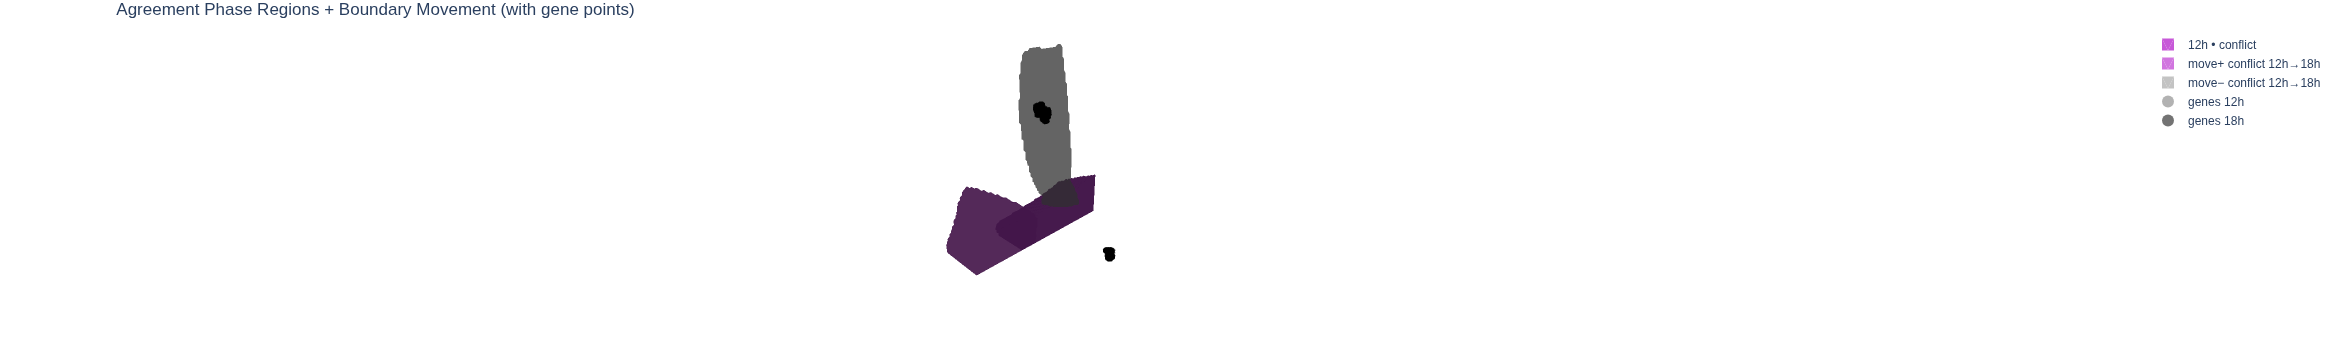

In [5]:
# === Agreement shells (GLB) + raw gene points (Plotly) ===
# pip install plotly pandas trimesh

import os
from pathlib import Path
import numpy as np
import pandas as pd
import trimesh
import plotly.graph_objects as go

# ---------- CONFIG ----------
OUT_DIR = Path("data/green_monkey/va_testing/agreement_phase")
TAG     = "chr1_vacv"

# times you exported; include only the ones you have
TIMES   = ["12h","18h"]  # add "24h" if available
CLASSES = ["agree_up", "agree_down", "conflict"]

# colors (match your pipeline)
CLASS_COLOR = {
    "agree_up":   "#ff7800",  # orange
    "agree_down": "#1eaaee",  # cyan/blue
    "conflict":   "#be3cd2",  # magenta
}
MOVE_NEG_COLOR = "#888888"    # inward shell (gray)

# raw gene point clouds (optional, for context)
GENE_XYZ = {
    "12h": "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv",
    "18h": "data/green_monkey/all_structure_files/chr1/18hrs/vacv/structure_18hrs_vacv_gene_info.csv",
    # "24h": "data/green_monkey/all_structure_files/chr1/24hrs/vacv/structure_24hrs_vacv_gene_info.csv",
}
POINT_STYLE = {
    "12h": dict(size=2, color="black", opacity=0.30),
    "18h": dict(size=2, color="black", opacity=0.55),
    "24h": dict(size=2, color="black", opacity=0.80),
}
POINT_SUBSAMPLE = None  # e.g., 4000 to speed up

# show edges on shells?
WIREFRAME = False
WIRE_WIDTH = 1

# --------------------------------- HELPERS ---------------------------------
def _mesh_traces_from_trimesh(mesh, name, opacity=0.8, color=None, wireframe=False, wire_width=1):
    v = mesh.vertices
    f = mesh.faces
    traces = [
        go.Mesh3d(
            x=v[:,0], y=v[:,1], z=v[:,2],
            i=f[:,0], j=f[:,1], k=f[:,2],
            name=name, opacity=opacity, color=color,
            flatshading=True, showscale=False,
            lighting=dict(ambient=0.35, diffuse=0.7, specular=0.2, roughness=0.7, fresnel=0.2),
            lightposition=dict(x=1, y=1, z=1),
            hoverinfo="skip", showlegend=True
        )
    ]
    if wireframe:
        edges = np.vstack([f[:,[0,1]], f[:,[1,2]], f[:,[2,0]]])
        edges = np.unique(np.sort(edges, axis=1), axis=0)
        x = np.full(edges.shape[0]*3, np.nan)
        y = np.full_like(x, np.nan)
        z = np.full_like(x, np.nan)
        x[0::3] = v[edges[:,0],0]; x[1::3] = v[edges[:,1],0]
        y[0::3] = v[edges[:,0],1]; y[1::3] = v[edges[:,1],1]
        z[0::3] = v[edges[:,0],2]; z[1::3] = v[edges[:,1],2]
        traces.append(go.Scatter3d(
            x=x, y=y, z=z, mode="lines",
            line=dict(width=wire_width), name=name+" (edges)",
            hoverinfo="skip", showlegend=False
        ))
    return traces

def _scene_meshes(scene):
    """Return list of Trimesh meshes in world coords from a scene or mesh."""
    if isinstance(scene, trimesh.Scene):
        try:
            return scene.dump(concatenate=False)
        except Exception:
            meshes = []
            for geom_name, mesh in scene.geometry.items():
                T = scene.graph.get_transform(geom_name)
                m = mesh.copy(); m.apply_transform(T)
                meshes.append(m)
            return meshes
    return [scene]

def _load_gene_points(csv_path, cols=("middle_x","middle_y","middle_z"), subsample=None):
    df = pd.read_csv(csv_path)
    pts = df[list(cols)].dropna().values.astype(np.float32)
    if subsample is not None and subsample < len(pts):
        idx = np.random.default_rng(42).choice(len(pts), subsample, replace=False)
        pts = pts[idx]
    return pts

def _add_points_trace(fig, pts, name, style):
    fig.add_trace(go.Scatter3d(
        x=pts[:,0], y=pts[:,1], z=pts[:,2], mode="markers",
        marker=dict(size=style.get("size",2), color=style.get("color","black"),
                    opacity=style.get("opacity",0.5)),
        name=name, hoverinfo="skip", showlegend=True
    ))

# --------------------------------- MAIN VIEW ---------------------------------
def show_agreement_shells_and_points(
    out_dir: Path,
    tag: str,
    times,
    classes,
    gene_xyz: dict = None,
    wireframe: bool = False,
    wire_width: int = 1,
    camera_eye=(1.6,1.6,1.2),
):
    fig = go.Figure()
    n_added = 0

    # 1) Phase region shells per time / class
    for t in times:
        for cls in classes:
            glb = out_dir / f"{tag}_{t}_{cls}_region.glb"
            if not glb.exists():
                continue
            scene = trimesh.load(glb.as_posix(), force='scene')
            title = f"{t} • {cls}"
            for idx, mesh in enumerate(_scene_meshes(scene)):
                for tr in _mesh_traces_from_trimesh(
                    mesh,
                    name=title if idx==0 else f"{title}:{idx}",
                    opacity=0.85,
                    color=CLASS_COLOR.get(cls, None),
                    wireframe=wireframe,
                    wire_width=wire_width
                ):
                    fig.add_trace(tr); n_added += 1

    # 2) Boundary movement shells (t1->t2), outward (+) = class color, inward (-) = gray
    if len(times) >= 2:
        t1, t2 = times[0], times[1]
        for cls in classes:
            pos_glb = out_dir / f"{tag}_{cls}_boundary_move_pos_{t1}_to_{t2}.glb"
            neg_glb = out_dir / f"{tag}_{cls}_boundary_move_neg_{t1}_to_{t2}.glb"
            if pos_glb.exists():
                scene = trimesh.load(pos_glb.as_posix(), force='scene')
                for idx, mesh in enumerate(_scene_meshes(scene)):
                    for tr in _mesh_traces_from_trimesh(
                        mesh, name=f"move+ {cls} {t1}→{t2}",
                        opacity=0.7, color=CLASS_COLOR.get(cls, None),
                        wireframe=wireframe, wire_width=wire_width
                    ):
                        fig.add_trace(tr); n_added += 1
            if neg_glb.exists():
                scene = trimesh.load(neg_glb.as_posix(), force='scene')
                for idx, mesh in enumerate(_scene_meshes(scene)):
                    for tr in _mesh_traces_from_trimesh(
                        mesh, name=f"move− {cls} {t1}→{t2}",
                        opacity=0.5, color=MOVE_NEG_COLOR,
                        wireframe=wireframe, wire_width=wire_width
                    ):
                        fig.add_trace(tr); n_added += 1

    # 3) Raw gene points (context)
    if gene_xyz:
        for t, csv_path in gene_xyz.items():
            if not Path(csv_path).exists():
                continue
            pts = _load_gene_points(csv_path, subsample=POINT_SUBSAMPLE)
            style = POINT_STYLE.get(t, dict(size=2, color="black", opacity=0.5))
            _add_points_trace(fig, pts, name=f"genes {t}", style=style)

    if n_added == 0:
        raise SystemExit("No GLBs found. Make sure you ran the partitioning script and OUT_DIR/TAG are correct.")

    # Layout: no axes boxes, keep aspect ratio, nice camera
    fig.update_scenes(
        xaxis_visible=False, yaxis_visible=False, zaxis_visible=False, aspectmode="data"
    )
    fig.update_layout(
        title="Agreement Phase Regions + Boundary Movement (with gene points)",
        scene_camera=dict(eye=dict(x=camera_eye[0], y=camera_eye[1], z=camera_eye[2])),
        legend=dict(itemsizing="constant"),
        margin=dict(l=0, r=0, t=30, b=0),
    )
    fig.show()
    return fig

# ------------------------------- RUN -------------------------------
if __name__ == "__main__":
    show_agreement_shells_and_points(
        OUT_DIR, TAG, TIMES, CLASSES,
        gene_xyz=GENE_XYZ,
        wireframe=WIREFRAME,
        wire_width=WIRE_WIDTH,
        camera_eye=(1.6, 1.6, 1.2)
    )
